# Masking and flattening HPF data with `TelFit` and Gaussian Processes

*gully*  
October 14, 2021

In [a previous tutorial](https://muler.readthedocs.io/en/latest/tutorials/Masking_and_flattening.html) we masked spectral lines and coarsely flattened the spectrum.  That approach was only able to identify the strongest telluric lines and therefore caused some residual weak telluric lines to distort the inferred continuum shape.  Also the third order polynomial was not flexible enough to account for high-frequency ringing artifacts leftover from the A0V's deep Hydrogen lines.

In this tutorial we use a pristine telluric template and [advanced Gaussian Process smoothing techniques](https://speakerdeck.com/dfm/an-astronomers-introduction-to-gaussian-processes-v2) to get an even more refined continuum fit.

In [1]:
from muler.hpf import HPFSpectrum
from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

We'll conduct the same steps as we did in [our previous tutorial on masking](https://muler.readthedocs.io/en/latest/tutorials/Masking_and_flattening.html).

In [3]:
filename = '../../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210801T083618_v1.0_0036.spectra.fits'
raw_spectrum = HPFSpectrum(file = filename, order=6)

In [4]:
spectrum = raw_spectrum.sky_subtract(method='vector').remove_nans().deblaze().normalize()

In [5]:
native_template = PHOENIXSpectrum(teff=9600, logg=5.0).normalize()

In [6]:
doctored_template = native_template\
                        .rotationally_broaden(105.0, u1=0.3)\
                        .rv_shift(-40.0)\
                        .instrumental_broaden(resolving_power=55_000)\
                        .resample(spectrum)\
                        .normalize()

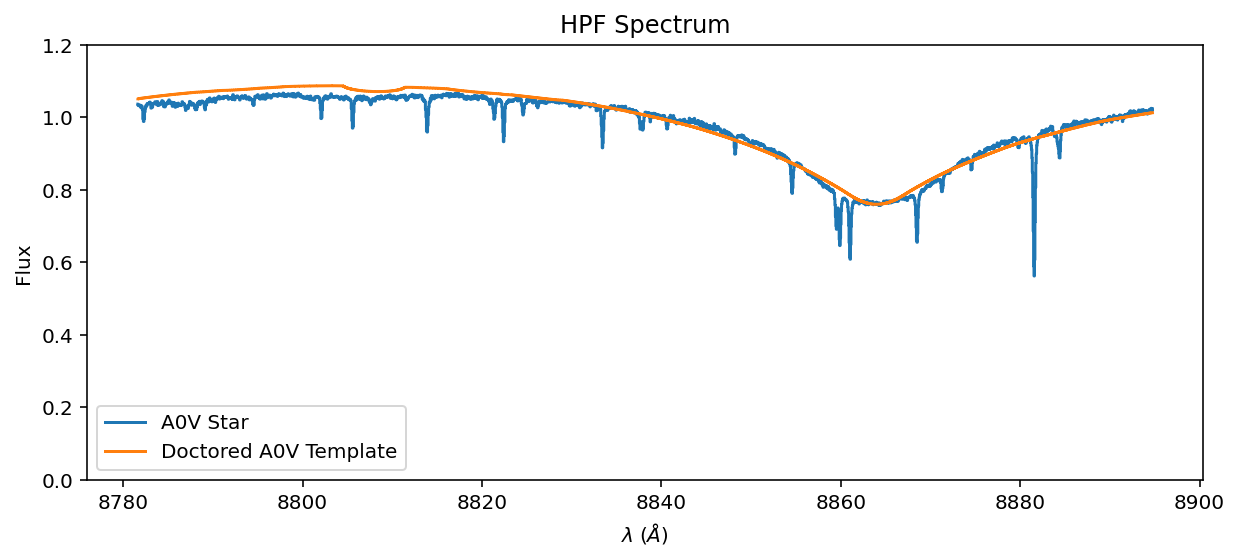

In [7]:
ax = spectrum.plot(ylo=0, label='A0V Star');
doctored_template.plot(ax=ax, label='Doctored A0V Template'); ax.legend();

In [8]:
telluric_response = spectrum.divide(doctored_template, handle_meta='ff')

Normalize by the top 5$^{th}$ percentile, rather than the median.

In [9]:
spectrum_peak = np.percentile(telluric_response.flux, 95)

In [10]:
telluric_response = telluric_response.divide(spectrum_peak, handle_meta='ff')

## Masking the lines with a template

`muler` now packages a static telluric template with its source code.  The template is not tunable and is inadequate for directly dividing out the telluric absorption.  Instead, we use this template for a coarse estimate of which spectral regions are likely to have the most severe telluric absorption.

In [11]:
telfit_template = telluric_response.get_static_TelFit_template()

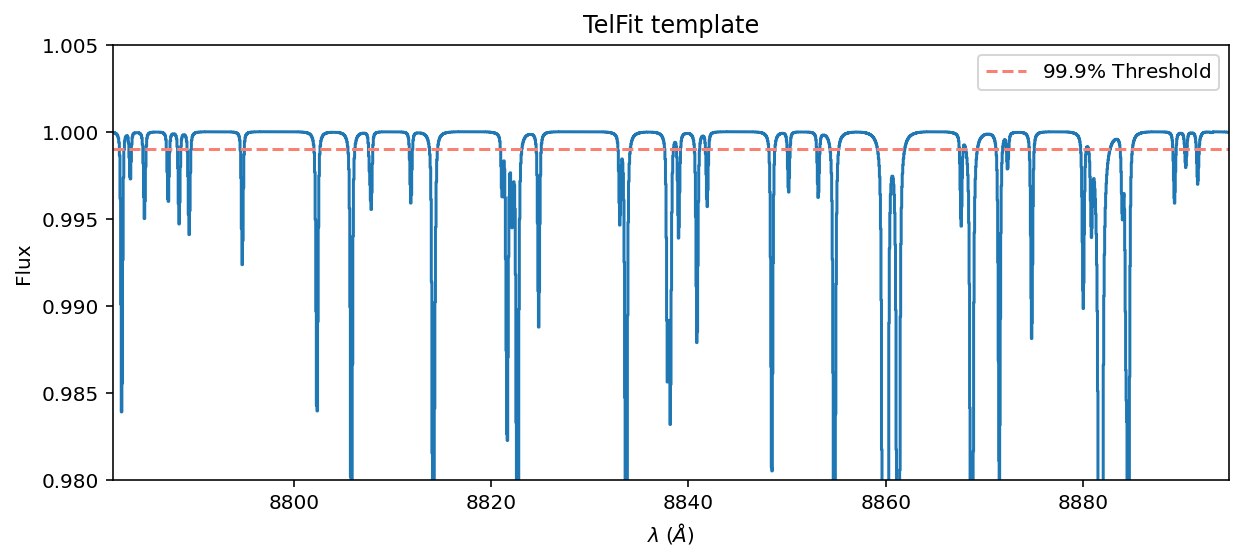

In [12]:
ax = telfit_template.plot(ylo=0.98, yhi=1.005)
ax.set_xlim(telluric_response.wavelength.value.min(), 
            telluric_response.wavelength.value.max());
ax.axhline(0.999, linestyle='dashed', color='salmon', label='$99.9\%$ Threshold');
plt.title('TelFit template')
ax.legend();

In the next cell we will mask the pixels in our telluric response spectrum that TelFit would expect to have greater than 0.1% telluric absorption.  You can tune the threshold to a higher or lower number depending on your needs.  The `dilation=N` parameter also masks $N$ adjacent pixels and accounts for the possibility of wavelength miscalibration in the data or model.

In [13]:
continuum = telluric_response.mask_tellurics(threshold=0.999, dilation=7)

In [14]:
smoothed_continuum, gp_model = continuum.smooth_spectrum(return_model=True)

In [15]:
inferred_continuum_flux = gp_model(telluric_response.wavelength.value)

In [16]:
inferred_continuum = telluric_response._copy(flux=inferred_continuum_flux 
                                            * u.dimensionless_unscaled,
                                             uncertainty=None)

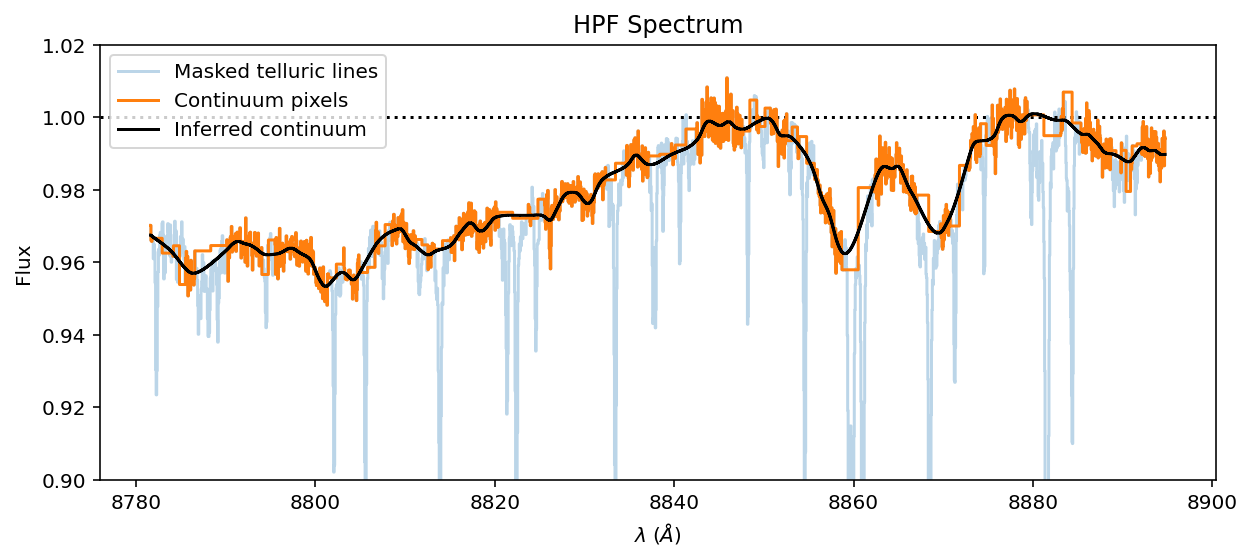

In [17]:
ax = telluric_response.plot(ylo=0.90, yhi=1.02, alpha=0.3, label='Masked telluric lines');
ax.axhline(1.0, color='k', linestyle='dotted');
continuum.plot(ax=ax, label='Continuum pixels')
inferred_continuum.plot(ax=ax, color='k', label='Inferred continuum')
ax.legend();

Neat! That continuum fit looks plausible.  You can see that we missed some telluric lines, such as the one at $\lambda \sim 8825$.  But overall it does an OK job. Let's flatten the spectrum by this inferred continuum.

In [18]:
flattened_telluric_response = telluric_response.divide(inferred_continuum, handle_meta='ff')

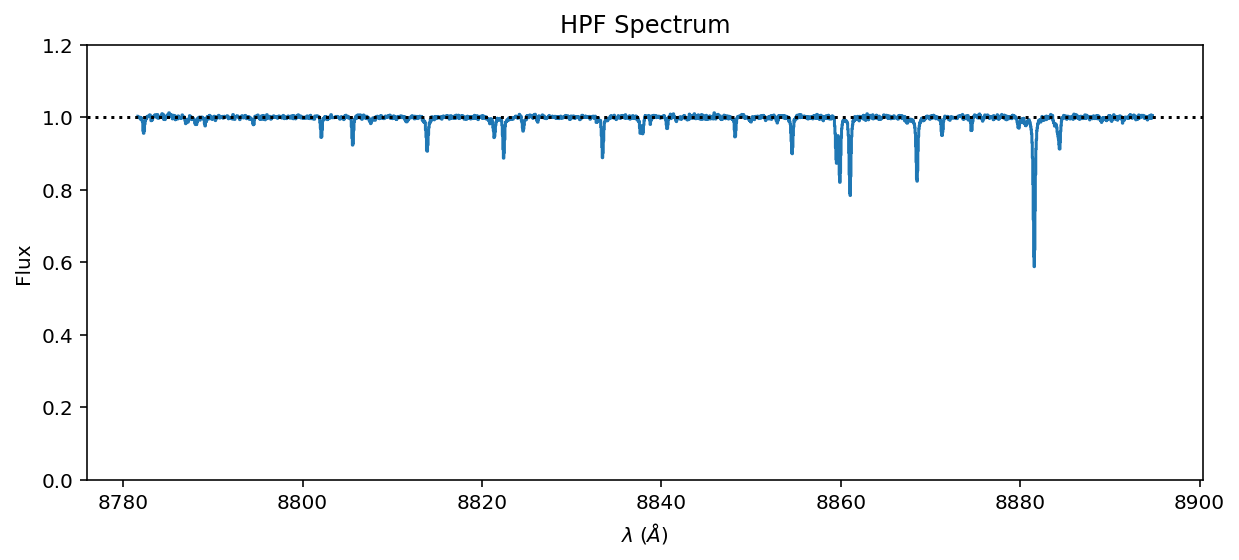

In [19]:
ax = flattened_telluric_response.plot(ylo=0)
ax.axhline(1.0, linestyle='dotted', color='k');

Nice! Much flatter than before!  The Hydrogen ringing artifacts are gone.  We can now measure precision equivalent widths by summing pixels without having to worry about where to place the continuum.  

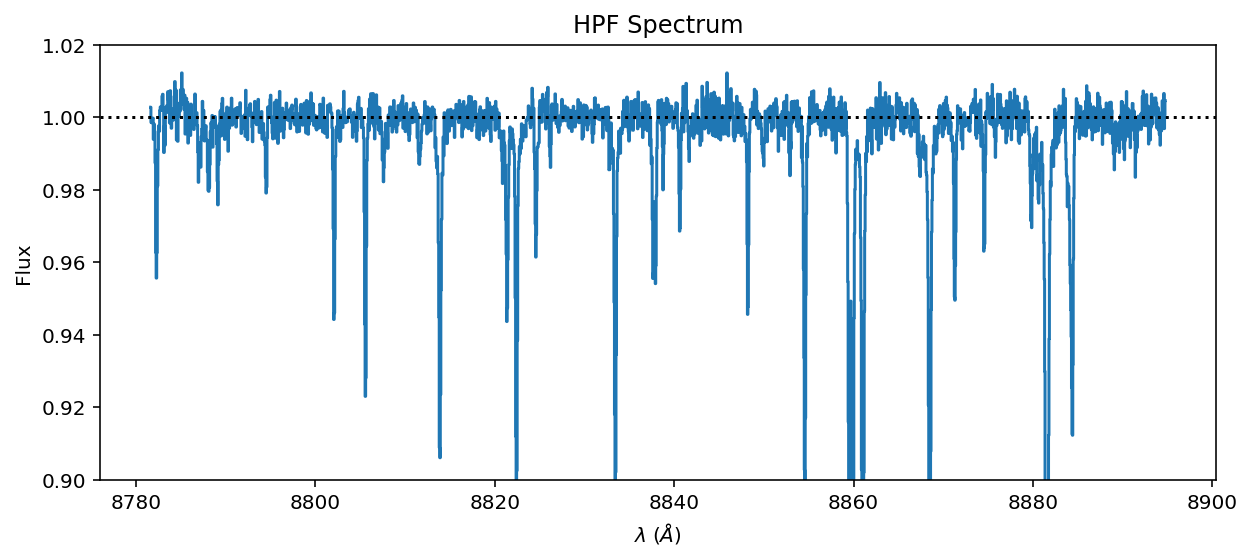

In [20]:
ax = flattened_telluric_response.plot(ylo=0.90, yhi=1.02)
ax.axhline(1.0, linestyle='dotted', color='k');

### Limitations 

The GP smoothing process is inherently an inference procedure, and may cause some undetermined amount of self-subtraction or artifical boosting.  An even-more-precise approach could be to fit directly for the lines with their real line shapes, based on measured or inferred atmospheric conditions at the time of the measurement.  TelFit and other frameworks offer such methods for telluric lines, and spectral synthesis for stars is also possible.